In [3]:
import zipfile
import os

# Path to the uploaded zip file
zip_file_path = '/content/coral_5k.zip'  # Replace with your file path

# Destination folder to extract the contents
destination_folder = '/content/coral_5k_unzip'
os.makedirs(destination_folder, exist_ok=True)

# Check if the file exists and is a valid zip file
if os.path.exists(zip_file_path):
    try:
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            # If it's a valid zip file, print the file names inside
            print("Files in the zip archive:")
            for file_name in zip_ref.namelist():
                print(file_name)
            # Extract the zip file
            zip_ref.extractall(destination_folder)
            print(f"Files extracted to {destination_folder}")
    except zipfile.BadZipFile:
        print(f"Error: {zip_file_path} is not a valid zip file or is corrupted.")
else:
    print(f"Error: {zip_file_path} does not exist.")

Streaming output truncated to the last 5000 lines.
Corel-5k/images/189050_aug_rot_90.jpeg
Corel-5k/images/189051.jpeg
Corel-5k/images/189051_aug.jpeg
Corel-5k/images/189051_aug_hor_flip.jpeg
Corel-5k/images/189051_aug_rot_90.jpeg
Corel-5k/images/189052.jpeg
Corel-5k/images/189052_aug.jpeg
Corel-5k/images/189052_aug_hor_flip.jpeg
Corel-5k/images/189052_aug_rot_90.jpeg
Corel-5k/images/189053.jpeg
Corel-5k/images/189053_aug.jpeg
Corel-5k/images/189053_aug_hor_flip.jpeg
Corel-5k/images/189053_aug_rot_90.jpeg
Corel-5k/images/189054.jpeg
Corel-5k/images/189054_aug.jpeg
Corel-5k/images/189054_aug_hor_flip.jpeg
Corel-5k/images/189054_aug_rot_90.jpeg
Corel-5k/images/189055.jpeg
Corel-5k/images/189055_aug.jpeg
Corel-5k/images/189055_aug_hor_flip.jpeg
Corel-5k/images/189055_aug_rot_90.jpeg
Corel-5k/images/189056.jpeg
Corel-5k/images/189056_aug.jpeg
Corel-5k/images/189056_aug_hor_flip.jpeg
Corel-5k/images/189056_aug_rot_90.jpeg
Corel-5k/images/189057.jpeg
Corel-5k/images/189057_aug.jpeg
Corel-5k/i

In [4]:
from IPython import get_ipython
from IPython.display import display
import cv2
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
from PIL import Image
import os

In [5]:
def calculate_msd_descriptor(image, block_size=8, color_bins=8):
    # Convert image to HSV color space
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Get image dimensions
    height, width, _ = image_hsv.shape

    # Initialize list to hold MSD feature vectors
    msd_features = []

    # Loop over the image blocks
    for i in range(0, height, block_size):
        for j in range(0, width, block_size):
            # Extract block
            block = image_hsv[i:i+block_size, j:j+block_size]

            # Calculate color histogram for each channel (H, S, V)
            hist_h = cv2.calcHist([block], [0], None, [color_bins], [0, 180]).flatten()
            hist_s = cv2.calcHist([block], [1], None, [color_bins], [0, 256]).flatten()
            hist_v = cv2.calcHist([block], [2], None, [color_bins], [0, 256]).flatten()

            # Normalize histograms
            hist_h /= hist_h.sum() if hist_h.sum() != 0 else 1
            hist_s /= hist_s.sum() if hist_s.sum() != 0 else 1
            hist_v /= hist_v.sum() if hist_v.sum() != 0 else 1

            # Combine color histograms into one feature vector
            color_hist = np.hstack([hist_h, hist_s, hist_v])

            # Apply Sobel operator to compute gradients (edge orientation)
            sobelx = cv2.Sobel(cv2.cvtColor(block, cv2.COLOR_HSV2BGR), cv2.CV_64F, 1, 0, ksize=3)
            sobely = cv2.Sobel(cv2.cvtColor(block, cv2.COLOR_HSV2BGR), cv2.CV_64F, 0, 1, ksize=3)
            edge_orientation = np.arctan2(sobely, sobelx)

            # Create histogram of edge orientations
            edge_hist, _ = np.histogram(edge_orientation, bins=8, range=(-np.pi, np.pi))
            edge_hist = edge_hist.astype(np.float32) / edge_hist.sum() if edge_hist.sum() != 0 else 1

            # Concatenate color histograms and edge orientation histograms
            msd_feature = np.hstack([color_hist, edge_hist])

            # Append block MSD feature to the overall MSD descriptor
            msd_features.append(msd_feature)

    # Flatten the list of block features into a single feature vector for the image
    msd_descriptor = np.hstack(msd_features)

    return msd_descriptor

In [6]:
from tqdm import tqdm  # Import tqdm for progress bar
import cv2
import os
import numpy as np
from glob import glob

def load_images_from_folder(folder_path, img_size=(128, 128)):
    images = []
    image_paths = glob(os.path.join(folder_path, '*'))
    for img_path in tqdm(image_paths, desc="Loading Images"):  # Add progress bar here
        img = cv2.imread(img_path)
        img = cv2.resize(img, img_size)
        images.append((img_path, img))
    return images

# Define the folder path
dataset_folder = '/content/coral_5k_unzip/Corel-5k/images'
images = load_images_from_folder(dataset_folder)

# Compute MSD descriptors for all images in the dataset with progress indication
image_descriptors = []
for img_path, img in tqdm(images, desc="Computing MSD Descriptors"):  # Add progress bar here
    descriptor = calculate_msd_descriptor(img)
    image_descriptors.append((img_path, descriptor))

# Check completion
print("Completed computing MSD descriptors for all images.")


Computing MSD Descriptors: 100%|██████████| 18500/18500 [21:31<00:00, 14.33it/s]

Completed computing MSD descriptors for all images.


In [9]:
import csv

# Save as CSV
with open("image_descriptors.csv", "w", newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(["image_path", "descriptor"])  # Header
    for img_path, descriptor in image_descriptors:
        writer.writerow([img_path, descriptor.tolist()])


In [10]:
import pandas as pd
df=pd.read_csv('/content/image_descriptors.csv')
df.head()



,image_path,descriptor
0,/content/coral_5k_unzip/Corel-5k/images/148011...,"[0.09375, 0.46875, 0.15625, 0.078125, 0.203125..."
1,/content/coral_5k_unzip/Corel-5k/images/152057...,"[0.0, 0.0, 0.0, 0.078125, 0.921875, 0.0, 0.0, ..."
2,/content/coral_5k_unzip/Corel-5k/images/22095_...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ..."
3,/content/coral_5k_unzip/Corel-5k/images/119093...,"[0.0, 0.296875, 0.125, 0.125, 0.453125, 0.0, 0..."
4,/content/coral_5k_unzip/Corel-5k/images/147021...,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."


to **to find similar images from the csv file**

In [ ]:
# Define the similarity function
def calculate_similarity(query_descriptor, descriptors):
    similarities = []
    for img_path, descriptor in descriptors:
        distance = euclidean(query_descriptor, descriptor)
        similarities.append((img_path, distance))
    # Sort based on distance (lower is more similar)
    similarities.sort(key=lambda x: x[1])
    return similarities

# Choose a query image (e.g., the 6th image in the dataset)
query_image = images[5][1]
query_descriptor = calculate_msd_descriptor(query_image)

# Calculate similarities
similar_images = calculate_similarity(query_descriptor, image_descriptors)
top_n = 5

# Display the query image
fig, axes = plt.subplots(1, top_n + 1, figsize=(15, 5))  # 1 row and top_n + 1 columns for query + similar images
axes[0].imshow(cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB))
axes[0].set_title("Query Image")
axes[0].axis('off')

# Display top 5 most similar images horizontally

for i, (img_path, distance) in enumerate(similar_images[:top_n]):
    similar_img = cv2.imread(img_path)
    axes[i + 1].imshow(cv2.cvtColor(similar_img, cv2.COLOR_BGR2RGB))
    axes[i + 1].set_title(f"Similar Image {i+1}\nDistance: {distance:.2f}")
    axes[i + 1].axis('off')

plt.show()

**to calculate similarity usning the list of images **

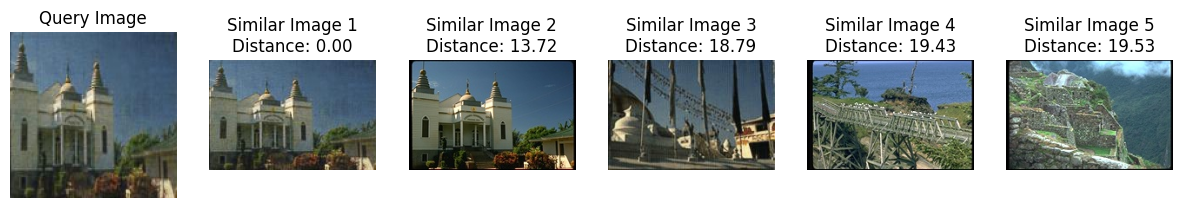

In [8]:
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean

# Define the similarity function
def calculate_similarity(query_descriptor, descriptors):
    similarities = []
    for img_path, descriptor in descriptors:
        distance = euclidean(query_descriptor, descriptor)
        similarities.append((img_path, distance))
    # Sort based on distance (lower is more similar)
    similarities.sort(key=lambda x: x[1])
    return similarities

# Choose a query image (e.g., the 6th image in the dataset)
query_image = images[5][1]
query_descriptor = calculate_msd_descriptor(query_image)

# Calculate similarities
similar_images = calculate_similarity(query_descriptor, image_descriptors)
top_n = 5

# Display the query image
fig, axes = plt.subplots(1, top_n + 1, figsize=(15, 5))  # 1 row and top_n + 1 columns for query + similar images
axes[0].imshow(cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB))
axes[0].set_title("Query Image")
axes[0].axis('off')

# Display top 5 most similar images horizontally

for i, (img_path, distance) in enumerate(similar_images[:top_n]):
    similar_img = cv2.imread(img_path)
    axes[i + 1].imshow(cv2.cvtColor(similar_img, cv2.COLOR_BGR2RGB))
    axes[i + 1].set_title(f"Similar Image {i+1}\nDistance: {distance:.2f}")
    axes[i + 1].axis('off')

plt.show()
